In [1]:
! pip install tensorflow
! pip show tensorflow

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1 -> 24.1.2
[notice] To update, run: C:\Users\wrksy\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages
Requires: tensorflow-intel
Required-by: 


In [2]:
! pip install google-cloud-aiplatform

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from google.cloud import aiplatform_v1
from google.cloud.aiplatform import gapic

import matplotlib.pyplot as plt
import os
import PIL
import shutil
import random
import glob
import itertools
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1 -> 24.1.2
[notice] To update, run: C:\Users\wrksy\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
train_dir = r"C:\\Users\\wrksy\\OneDrive\\Desktop\\Projects\\7088CEM\\Image_classification\\data\\training_set"
test_dir = r"C:\\Users\\wrksy\\OneDrive\\Desktop\\Projects\\7088CEM\\Image_classification\\data\\test_set"


def count_images_in_folders(directory):
    folders = os.listdir(directory)
    for folder in folders:
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            images_count = len(os.listdir(folder_path))
            print(f"Folder: {folder}, Images Count: {images_count}")

print("Train Set:")
count_images_in_folders(train_dir)

print("\nTest Set:")
count_images_in_folders(test_dir)

Train Set:
Folder: cats, Images Count: 4001
Folder: dogs, Images Count: 4006

Test Set:
Folder: cats, Images Count: 1012
Folder: dogs, Images Count: 1013


In [9]:
## Data Preparation
## Create Validation dataset
valid_dir = r"C:\\Users\\wrksy\\OneDrive\\Desktop\\Projects\\7088CEM\\Image_classification\\data\\validation_set"
new_test_dir = r"C:\\Users\\wrksy\\OneDrive\\Desktop\\Projects\\7088CEM\\Image_classification\\data\\new_test_set"

# Create validation directory if not exists
os.makedirs(valid_dir, exist_ok=True)

# Function to copy files
def copy_files(src_dir, dst_dir, category, num_files):
    os.makedirs(os.path.join(dst_dir, category), exist_ok=True)
    files = os.listdir(os.path.join(src_dir, category))
    num_files_to_copy = min(num_files, len(files))
    files_to_copy = files[:num_files_to_copy]
    for file in files_to_copy:
        src_path = os.path.join(src_dir, category, file)
        dst_path = os.path.join(dst_dir, category, file)
        shutil.copy(src_path, dst_path)
        
# Copy 500 cats and 500 dogs from test set to validation set
copy_files(test_dir, valid_dir, 'cats', 500)
copy_files(test_dir, valid_dir, 'dogs', 500)

In [10]:
print("Train Set:")
count_images_in_folders(train_dir)

print("Valid_dir:")
count_images_in_folders(valid_dir)

print("Test Set:")
count_images_in_folders(test_dir)

Train Set:
Valid_dir:
Test Set:


{'cats': 1012, 'dogs': 1013}

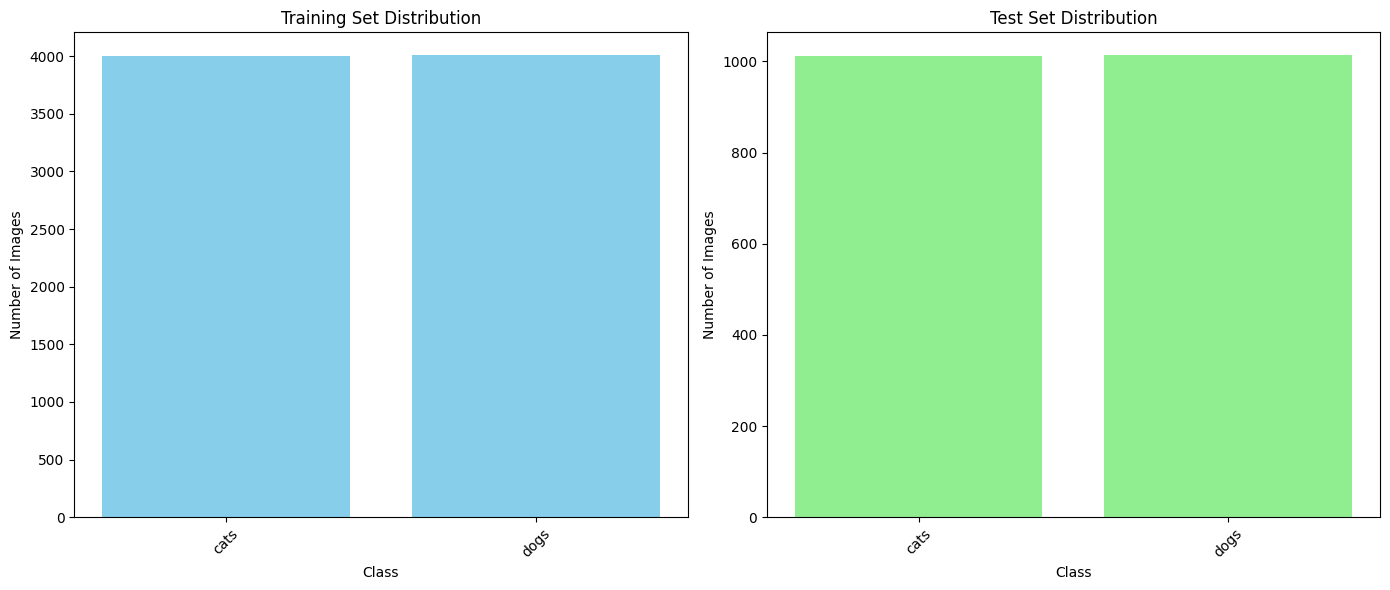

In [11]:
# distribution of images across different classes in both the training and test datasets.
def count_images_in_folders(directory):
    folder_counts = {}
    folders = os.listdir(directory)
    for folder in folders:
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            images_count = len(os.listdir(folder_path))
            folder_counts[folder] = images_count
    return folder_counts

train_counts = count_images_in_folders(train_dir)
test_counts = count_images_in_folders(test_dir)

# Plotting the distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Training set distribution
axes[0].bar(train_counts.keys(), train_counts.values(), color='skyblue')
axes[0].set_title('Training Set Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=45)

# Test set distribution
axes[1].bar(test_counts.keys(), test_counts.values(), color='lightgreen')
axes[1].set_title('Test Set Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Images')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [12]:
## Setting ImageDataGenerator to ensure the imported libraries before modelling

# Define the image size and batch size
image_size = (224, 224)
batch_size = 10

# Create an ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

# Create the train_batches using flow_from_directory
train_batches = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have more than 2 classes
    shuffle=True  # Shuffle the data for better training
)

# Create the test_batches using flow_from_directory
test_batches = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have more than 2 classes
    shuffle=False  # Do not shuffle the test data
)

# Create the valid_batches using flow_from_directory
valid_batches = datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have more than 2 classes
    shuffle=False  # Do not shuffle the validation data
)


Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
assert train_batches.samples == 8005, f"Expected 8005 samples in train_batches, but got {train_batches.samples}"
assert test_batches.samples == 2023, f"Expected 2023 samples in test_batches, but got {test_batches.samples}"
assert valid_batches.samples == 1000, f"Expected 1000 samples in valid_batches, but got {valid_batches.samples}"

assert train_batches.num_classes == test_batches.num_classes == valid_batches.num_classes == 2, \
    f"Expected 2 classes in all batches, but got {train_batches.num_classes}, {test_batches.num_classes}, {valid_batches.num_classes}"




In [14]:
## Seperate labels with images for training
imgs, labels = next(train_batches)

In [15]:
## Data Visualization
## Post preprocess visualization with vgg16
def plotImages(images_arr) :
    fig, axes = plt.subplots(1, 10, figsize = (20,20))
    axes = axes. flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..97.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-108.68..97.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-108.68..151.061].
Clipping input data to 

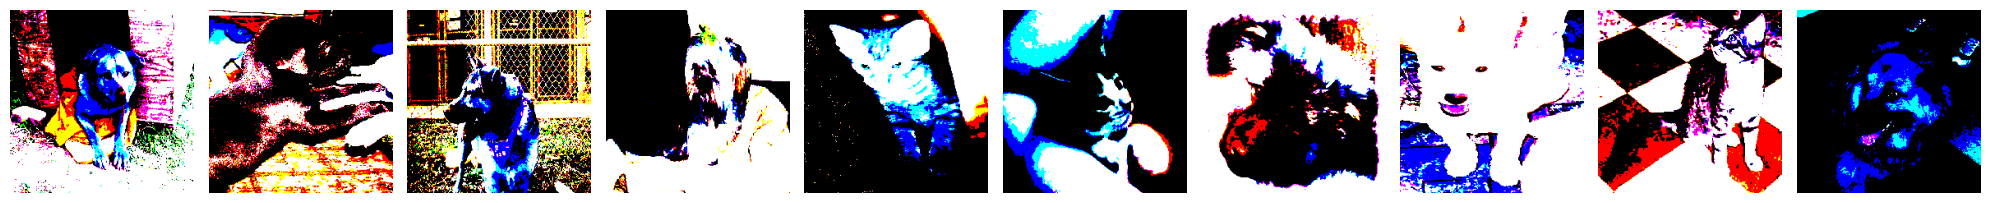

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [16]:
plotImages(imgs)
print(labels)

In [12]:
## Build and Train CNN
## Create Model
model = Sequential([
  Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(224,224,3)),
  MaxPool2D(pool_size=(2,2), strides=2),
  Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  MaxPool2D(pool_size=(2,2), strides=2),
  Flatten(),
  Dense(units=2, activation='softmax'),
])

C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Summary Model
model.summary()
Model: "sequential"

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │       401,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,802 (1.61 MB)

 Trainable params: 420,802 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Compile Model

In [14]:
model.compile(optimizer= Adam(learning_rate = 0.0001),
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

Fitting Model


In [15]:
model.fit(
  x=train_batches,
  validation_data=valid_batches,
  epochs=10,
  verbose=2
)

Epoch 1/3


C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


801/801 - 183s - 228ms/step - accuracy: 0.6371 - loss: 3.1944 - val_accuracy: 0.6670 - val_loss: 0.7003
Epoch 2/3
801/801 - 137s - 171ms/step - accuracy: 0.8656 - loss: 0.3328 - val_accuracy: 0.7000 - val_loss: 0.8255
Epoch 3/3
801/801 - 128s - 160ms/step - accuracy: 0.9621 - loss: 0.1136 - val_accuracy: 0.7010 - val_loss: 0.8950


In [16]:
# Model Prediction
predictions = model.predict(x=test_batches, verbose=0)

In [17]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [18]:
# Create Confusion Matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          text_color='black'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color=text_color)  # Change text color here
                 #color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [20]:
test_batches.class_indices

{'cats': 0, 'dogs': 1}

Confusion matrix, without normalization


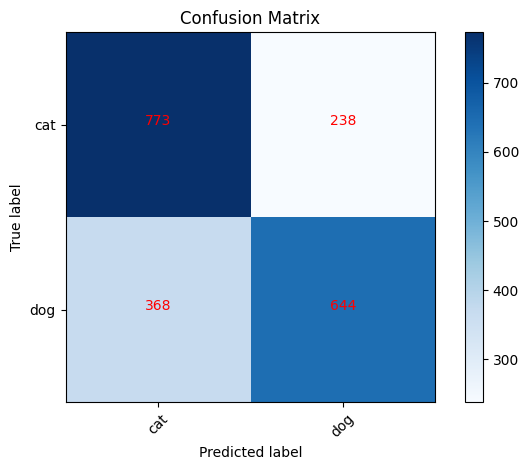

In [21]:
cm_plot_label = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_label, title='Confusion Matrix', text_color='red')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-104.68..142.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..104.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-100.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..138.22101].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..137.061].
Clipping input dat

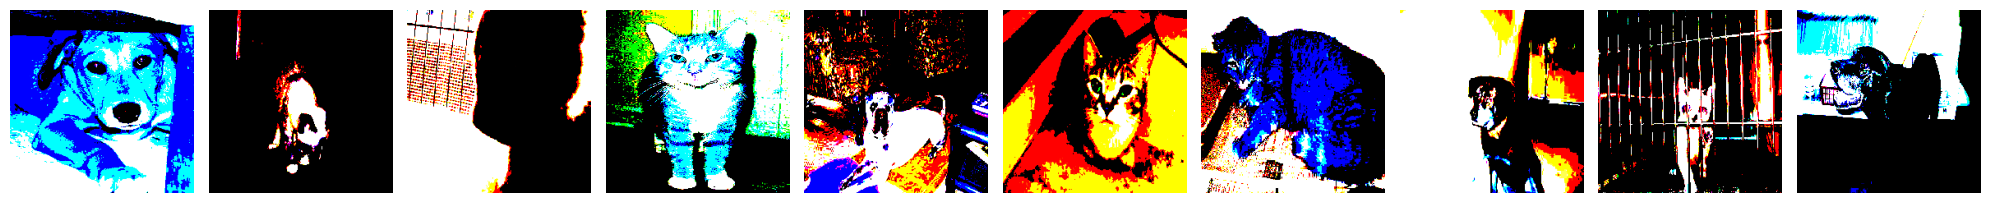

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [22]:
# Create plot function
def plotImages(images_arr) :
    fig, axes = plt.subplots(1, 10, figsize = (20,20))
    axes = axes. flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
# Print images & labels
plotImages(imgs)
print(labels)

In [23]:
# Download model from "https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16"
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [24]:
# Print model structure
# Vgg16 Model Summary
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Create function for count_params
def count_params(model):
    """Count the total number of trainable and non-trainable parameters in the model."""
    non_trainable_params = sum(v.shape.num_elements() for v in model.non_trainable_weights)
    trainable_params = sum(v.shape.num_elements() for v in model.trainable_weights)
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

# Call the function to get the counts
params = count_params(vgg16_model)

# Print the counts
print("Total trainable parameters:", params['trainable_params'])
print("Total non-trainable parameters:", params['non_trainable_params'])

Total trainable parameters: 138357544
Total non-trainable parameters: 0


In [26]:
# Call the function to get the counts
params = count_params(vgg16_model)

# Check the counts
assert params['non_trainable_params'] == 0
assert params['trainable_params'] == 138357544

In [27]:
# Create a new Sequential model
# Build Sequential Model from Vgg16 Model
model = Sequential()

# Add layers from the VGG16 model to the new Sequential model
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [28]:
# Print new Sequential Model Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Call the function to get the counts
params = count_params(model)

# Check the counts
assert params['non_trainable_params'] == 0
assert params['trainable_params'] == 134260544

In [30]:
# Freeze all layers in the model
for layer in model.layers:
    layer.trainable = False

In [31]:
# Adding ouput layer with softmax activation function
model.add(Dense(units=2, activation='softmax'))

In [32]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [33]:
# Call the function to get the counts
params = count_params(model)

# Check the new counts
assert params['trainable_params'] == 8194
assert params['non_trainable_params'] == 134260544

Compile the Fine-Tuned Vgg16 model

In [34]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Train the model
# Train the Fine-Tuned Vgg16 model
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/3
801/801 - 1877s - 2s/step - accuracy: 0.9590 - loss: 0.1070 - val_accuracy: 0.9870 - val_loss: 0.0525
Epoch 2/3
801/801 - 1807s - 2s/step - accuracy: 0.9854 - loss: 0.0410 - val_accuracy: 0.9870 - val_loss: 0.0480
Epoch 3/3
801/801 - 2780s - 3s/step - accuracy: 0.9898 - loss: 0.0309 - val_accuracy: 0.9830 - val_loss: 0.0544


In [36]:
# Check if accuracy exceeds 95%
assert max(model.history.history['accuracy']) > 0.95

Predict on test batches

In [37]:
# Predict using the model
predictions = model.predict(x = test_batches, verbose=0)

In [38]:
# Calculate confusion matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [39]:
# Printing classes and labels
test_batches.class_indices

{'cats': 0, 'dogs': 1}

Confusion matrix, without normalization
[[1004    7]
 [  27  985]]


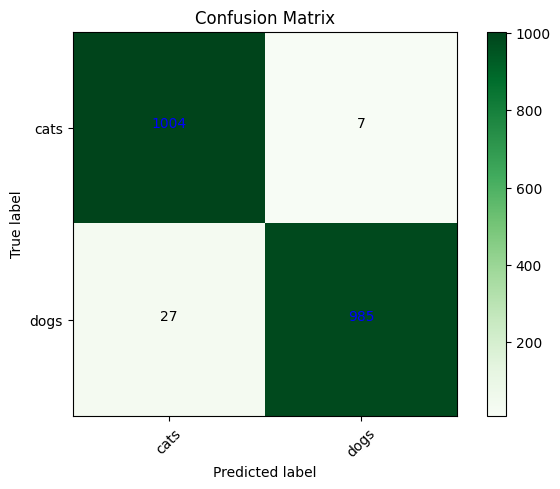

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="blue" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm_plot_labels = ['cats', 'dogs']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix', cmap=plt.cm.Greens)